In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from conllu import parse
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt

START_TOKEN = "<s>"
END_TOKEN = "</s>"
UNKNOWN_TOKEN = "<unk>"
PAD_TOKEN = "<pad>"

In [3]:
class POSDatatset_FFNN:
    def __init__(self, file_path, p=2, s=3, training_args=None):
        self.training_args = training_args
        if training_args != None:
            self.vocab = training_args['vocab']
            self.tags = training_args['tags']
            self.words_index = training_args['words_index']
            self.tags_index = training_args['tags_index']
        self.read_conllu(file_path)
        self.make_sequences(p, s)

    def read_conllu(self, file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            data = f.read()
            sentences = parse(data)

        if self.training_args == None:

            freq = {}
            tags = set()
            vocab = set()
            for sentence in sentences:
                for token in sentence:
                    vocab.add(token['form'])
                    tags.add(token['upostag'])
                    freq[token['form']] = freq.get(token['form'], 0)+1

            freq_cutoff = 3
            removed_words = set()
            for word in vocab:
                if (freq[word] < freq_cutoff):
                    removed_words.add(word)

            for word in removed_words:
                vocab.remove(word)

            vocab.add(START_TOKEN)
            vocab.add(END_TOKEN)
            vocab.add(UNKNOWN_TOKEN)

            label_encoder = LabelEncoder()
            self.tags = list(tags)
            self.vocab = list(vocab)
            encoded_tags = label_encoder.fit_transform(self.tags)
            encoded_words = label_encoder.fit_transform(self.vocab)

            self.tags_index = {}
            self.words_index = {}
            for i in range(len(tags)):
                self.tags_index[self.tags[i]] = encoded_tags[i]
            for i in range(len(vocab)):
                self.words_index[self.vocab[i]] = encoded_words[i]

        self.data = []
        for sentence in sentences:
            sente = []
            label = []
            for token in sentence:
                word = token['form']
                pos = token['upostag']
                if pos not in self.tags_index:
                    continue
                sente.append(self.words_index.get(
                    word, self.words_index[UNKNOWN_TOKEN]))
                label.append(self.tags_index[pos])
            self.data.append((sente, label))

    def make_sequences(self, p, s):
        self.X = []
        self.Y = []
        for i in range(len(self.data)):
            sentence = self.data[i][0]
            labels = self.data[i][1]
            for j in range(len(sentence)):
                x = []
                y = list(np.zeros(len(self.tags)))
                y[labels[j]] = 1
                for k in range(j-p, j+s+1):
                    # print(k)
                    if (k < 0):
                        x.append(self.words_index[START_TOKEN])
                    elif (k >= len(sentence)):
                        x.append(self.words_index[END_TOKEN])
                    else:
                        x.append(sentence[k])
                self.X.append(x)
                self.Y.append(y)
        self.X = torch.tensor(self.X)
        self.Y = torch.tensor(self.Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        sequence = self.X[index]
        label = self.Y[index]
        return sequence, label

In [4]:
class POSDatatset_LSTM:
    def __init__(self, file_path, training_args=None):
        self.training_args = training_args
        if training_args != None:
            self.vocab = training_args['vocab']
            self.words_index = training_args['words_index']
            self.tags_index = training_args['tags_index']
            self.tags_one_hot = training_args['tags_one_hot']
        self.read_conllu(file_path)

    def read_conllu(self, file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            data = f.read()
            sentences = parse(data)

        if self.training_args == None:

            freq = {}
            tags = set()
            vocab = set()
            for sentence in sentences:
                for token in sentence:
                    vocab.add(token['form'])
                    tags.add(token['upostag'])
                    freq[token['form']] = freq.get(token['form'], 0)+1

            freq_cutoff = 3
            removed_words = set()
            for word in vocab:
                if (freq[word] < freq_cutoff):
                    removed_words.add(word)

            for word in removed_words:
                vocab.remove(word)

            tags.add(PAD_TOKEN)

            vocab.add(UNKNOWN_TOKEN)
            vocab.add(PAD_TOKEN)

            label_encoder = LabelEncoder()
            self.tags = list(tags)
            self.vocab = list(vocab)
            encoded_tags = label_encoder.fit_transform(self.tags)
            encoded_words = label_encoder.fit_transform(self.vocab)

            self.tags_index = {}
            self.words_index = {}
            self.tags_one_hot = {}
            for i in range(len(tags)):
                self.tags_index[self.tags[i]] = encoded_tags[i]
                label = np.zeros(len(tags))
                label[encoded_tags[i]] = 1
                self.tags_one_hot[self.tags[i]] = list(label)
            for i in range(len(vocab)):
                self.words_index[self.vocab[i]] = encoded_words[i]

        max_len = 0
        for sentence in sentences:
            max_len = max(max_len, len(sentence))

        self.data = []
        for sentence in sentences:
            sente = []
            label = []
            for token in sentence:
                word = token['form']
                pos = token['upostag']
                if pos not in self.tags_one_hot:
                    sente.append(self.words_index[PAD_TOKEN])
                    label.append(self.tags_one_hot[PAD_TOKEN])
                    continue
                sente.append(self.words_index.get(
                    word, self.words_index[UNKNOWN_TOKEN]))
                label.append(self.tags_one_hot[pos])
            for i in range(max_len-len(sentence)):
                sente.append(self.words_index[PAD_TOKEN])
                label.append(self.tags_one_hot[PAD_TOKEN])
            self.data.append((torch.tensor(sente), torch.tensor(label)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sequence = self.data[index][0]
        label = self.data[index][1]
        return sequence, label

    # def collate(self, batch):
    #     sentences = [i[0] for i in batch]
    #     labels = [i[1] for i in batch]

    #     padded_sentences = pad_sequence(
    #         sentences, batch_first=True, padding_value=self.words_index[PAD_TOKEN])
    #     padded_labels = pad_sequence(
    #         labels, batch_first=True, padding_value=self.tags_index[PAD_TOKEN])

    #     one_hot_labels = []
    #     for sentence in padded_labels:
    #         labels = []
    #         for tag in sentence:
    #             label = np.zeros(len(self.tags))
    #             label[int(tag)] = 1
    #             labels.append(list(label))
    #         one_hot_labels.append(labels)
    #     one_hot_labels = torch.tensor(one_hot_labels)

    #     return padded_sentences, one_hot_labels

In [154]:
# class FFNN_Tagger(nn.Module):
#     def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, p, s):
#         super(FFNN_Tagger, self).__init__()
#         self.embedding = nn.Embedding(input_dim, embedding_dim)
#         self.fc1 = nn.Linear(embedding_dim*(p+s+1), hidden_dim)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         out = self.embedding(x)
#         out = out.view(out.size(0), -1)
#         out = self.fc1(out)
#         out = self.relu(out)
#         out = self.fc2(out)
#         return out

In [5]:
class FFNN_Tagger(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, p, s, hidden_layers=2, activation=nn.ReLU()):
        super(FFNN_Tagger, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.activation = activation
        self.ffnn = nn.Sequential()
        self.ffnn.add_module('linear1', module=nn.Linear(
            embedding_dim*(p+s+1), hidden_dim))
        self.ffnn.add_module('act1', module=activation)
        for i in range(hidden_layers-2):
            self.ffnn.add_module(
                f'linear{i+2}', module=nn.Linear(hidden_dim, hidden_dim))
            self.ffnn.add_module(f'act{i+2}', module=activation)
        self.ffnn.add_module(
            f'linear{hidden_layers}', module=nn.Linear(hidden_dim, output_dim))

    def forward(self, x):
        out = self.embedding(x)
        out = out.view(out.size(0), -1)
        out = self.ffnn(out)
        return out

In [6]:
class LSTM_Tagger(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, stacks, output_dim, bidirectional=False):
        super(LSTM_Tagger, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,
                            stacks, bidirectional=bidirectional)
        self.hidden_to_tag = nn.Linear(hidden_dim, output_dim)
        if bidirectional:
            self.hidden_to_tag = nn.Linear(2*hidden_dim, output_dim)

    def forward(self, x):
        out = self.embedding(x)
        out, (_, _) = self.lstm(out)
        out = self.hidden_to_tag(out)
        return out

In [9]:
train_filepath = "./ud-treebanks-v2.13/UD_English-Atis/en_atis-ud-train.conllu"
test_filepath = "./ud-treebanks-v2.13/UD_English-Atis/en_atis-ud-test.conllu"
dev_filepath = "./ud-treebanks-v2.13/UD_English-Atis/en_atis-ud-dev.conllu"

In [158]:
import nltk
import string


def tokenize_sentence(sentence):
    tokens = nltk.word_tokenize(sentence)
    tokens = [token.lower()
              for token in tokens if token not in string.punctuation]
    return tokens

In [24]:
class POS_Tagger:
    def __init__(self, type='ffnn'):
        self.type = type

    def train(self, train_dataset, embedding_dim=64, hidden_dim=128, p=2, s=3, model=None):

        self.p = p
        self.s = s
        self.train_dataset = train_dataset
        self.model = model

        train_dataloader = DataLoader(
            train_dataset, batch_size=32, shuffle=True)

        input_dim = len(train_dataset.vocab)
        output_dim = len(train_dataset.tags)

        if (model == None):
            if (self.type == 'ffnn'):
                self.model = FFNN_Tagger(
                    input_dim, embedding_dim, hidden_dim, output_dim, p, s)
            elif (self.type == 'lstm'):
                self.model = LSTM_Tagger(
                    input_dim, embedding_dim, hidden_dim, 1, output_dim)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)

        num_epochs = 10
        for epoch in range(num_epochs):
            total_loss = 0.0
            for inputs, labels in train_dataloader:
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            # print(f'Epoch {epoch+1}, Loss: {total_loss:.4f}')

        self.training_args = {'vocab': train_dataset.vocab, 'tags': train_dataset.tags,
                              'words_index': train_dataset.words_index, 'tags_index': train_dataset.tags_index}

    def train_graph(self, train_dataset, dev_dataset, embedding_dim=64, hidden_dim=128, p=2, s=3, model=None):

        self.p = p
        self.s = s
        self.train_dataset = train_dataset
        self.model = model

        train_dataloader = DataLoader(
            train_dataset, batch_size=32, shuffle=True)

        dev_dataloader = DataLoader(
            dev_dataset, batch_size=32, shuffle=True)

        input_dim = len(train_dataset.vocab)
        output_dim = len(train_dataset.tags)

        if (model == None):
            if (self.type == 'ffnn'):
                self.model = FFNN_Tagger(
                    input_dim, embedding_dim, hidden_dim, output_dim, p, s)
            elif (self.type == 'lstm'):
                self.model = LSTM_Tagger(
                    input_dim, embedding_dim, hidden_dim, 1, output_dim)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)

        accuracies = []

        num_epochs = 10
        for epoch in range(num_epochs):
            total_loss = 0.0
            for inputs, labels in train_dataloader:
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            # print(f'Epoch {epoch+1}, Loss: {total_loss:.4f}')
            y_true = []
            y_predicted = []
            with torch.no_grad():
                for inputs, labels in dev_dataloader:
                    outputs = self.model(inputs)
                    if (self.type == 'ffnn'):
                        _, predicted = outputs.max(1)
                        correct_labels = labels.argmax(1)
                    elif self.type == 'lstm':
                        _, predicted = outputs.max(2)
                        correct_labels = labels.argmax(2)
                    y_true.extend(correct_labels.view(-1))
                    y_predicted.extend(predicted.view(-1))
            accuracy = accuracy_score(y_true, y_predicted)
            accuracies.append(accuracy)

        self.training_args = {'vocab': train_dataset.vocab, 'tags': train_dataset.tags,
                              'words_index': train_dataset.words_index, 'tags_index': train_dataset.tags_index}

        plt.plot(range(1, num_epochs+1), accuracies, marker='o')
        plt.title('Dev Set Accuracy vs Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Dev Set Accuracy')
        plt.xticks(range(1, num_epochs+1))
        plt.grid(True)
        plt.show()

    def evaluate(self, test_dataset):
        test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
        y_true = []
        y_predicted = []
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                outputs = self.model(inputs)
                if (self.type == 'ffnn'):
                    _, predicted = outputs.max(1)
                    correct_labels = labels.argmax(1)
                elif self.type == 'lstm':
                    _, predicted = outputs.max(2)
                    correct_labels = labels.argmax(2)
                y_true.extend(correct_labels.view(-1))
                y_predicted.extend(predicted.view(-1))
        accuracy = accuracy_score(y_true, y_predicted)
        recall = recall_score(y_true, y_predicted, average='weighted')
        f1_micro = f1_score(y_true, y_predicted, average='micro')
        f1_macro = f1_score(y_true, y_predicted, average='macro')
        confusion_mat = confusion_matrix(y_true, y_predicted)
        return accuracy, recall, f1_micro, f1_macro, confusion_mat

    def predict(self, sentence):
        words = tokenize_sentence(sentence)
        sente = []
        for word in words:
            sente.append(self.train_dataset.words_index.get(
                word, self.train_dataset.words_index[UNKNOWN_TOKEN]))
        tokens = sente

        X = []

        if self.type == 'ffnn':
            for i in range(len(tokens)):
                x = []
                for j in range(i-self.p, i+self.s+1):
                    if (j < 0):
                        x.append(self.train_dataset.words_index[START_TOKEN])
                    elif (j >= len(tokens)):
                        x.append(self.train_dataset.words_index[END_TOKEN])
                    else:
                        x.append(tokens[j])
                X.append(x)

            X = torch.tensor(X)
            output = self.model(X)
            _, predicted = output.max(1)

            index_tags = {}
            index_words = {}

            for k, v in self.train_dataset.words_index.items():
                index_words[v] = k
            for k, v in self.train_dataset.tags_index.items():
                index_tags[v] = k

            for i in range(len(X)):
                print(words[i], index_tags[int(predicted[i])])

        elif self.type == 'lstm':
            X.append(tokens)
            X = torch.tensor(X)

            output = self.model(X)
            _, predicted = output.max(2)

            index_tags = {}
            index_words = {}

            for k, v in self.train_dataset.words_index.items():
                index_words[v] = k
            for k, v in self.train_dataset.tags_one_hot.items():
                index_tags[np.array(v).argmax()] = k

            for i in range(len(tokens)):
                # print(index_words.get(int(tokens[i]),UNKNOWN_TOKEN),index_tags[int(predicted[i])])
                print(words[i], index_tags[int(predicted[0][i])])

In [25]:
p = 2
s = 3
train_dataset = POSDatatset_FFNN(train_filepath, p, s)
training_args = {'vocab': train_dataset.vocab, 'tags': train_dataset.tags,
                 'words_index': train_dataset.words_index, 'tags_index': train_dataset.tags_index}
test_dataset = POSDatatset_FFNN(test_filepath, p, s, training_args)
dev_dataset = POSDatatset_FFNN(dev_filepath, p, s, training_args)

tagger = POS_Tagger()
tagger.train(train_dataset)
accuracy, recall, f1_micro, f1_macro, confusion_mat = tagger.evaluate(
    test_dataset)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 micro:", f1_micro)
print("F1 macro:", f1_macro)
print('Confusion matrix', confusion_mat)
# tagger.evaluate(dev_dataset)
accuracy, recall, f1_micro, f1_macro, confusion_mat = tagger.evaluate(
    dev_dataset)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 micro:", f1_micro)
print("F1 macro:", f1_macro)
print('Confusion matrix', confusion_mat)

Accuracy: 0.9770516717325228
Recall: 0.9770516717325228
F1 micro: 0.9770516717325228
F1 macro: 0.9454517732843694
Confusion matrix [[ 209    0    4    0    0    0    1    2    0    0    0    3    1]
 [   0 1424    2    0    0    3    0    1    1    1    2    0    0]
 [  13    1   54    1    0    0    0    1    0    0    0    5    1]
 [   0    0    0  252    0    0    0    0    0    0    0    1    3]
 [   0    0    1    0  106    0    0    2    0    0    0    0    0]
 [   0    1    0    0    0  501    1    1    0    0    7    1    0]
 [   0    0    0    0    0    0   35    0    0    0    0    0    1]
 [   1    0    0    1    0    0    0 1151    2    0    0    9    2]
 [   0    0    0    0    0    1    0    3  118    0    1    4    0]
 [   0   14    0    0    0    0    0    0    0   42    0    0    0]
 [   0    0    0    0    0    2    0    0    1    0  389    0    0]
 [   1    1    2    0    0    0    0    2    3    0    0 1556    2]
 [   7   10    0    4    0    0    0    8    3    0  

In [161]:
tagger.predict("An apple a day")

an DET
apple VERB
a DET
day NOUN


In [26]:
train_dataset = POSDatatset_LSTM(train_filepath)
training_args = {'vocab': train_dataset.vocab, 'tags': train_dataset.tags, 'words_index': train_dataset.words_index,
                 'tags_index': train_dataset.tags_index, 'tags_one_hot': train_dataset.tags_one_hot}
test_dataset = POSDatatset_LSTM(test_filepath, training_args)
dev_dataset = POSDatatset_LSTM(dev_filepath, training_args)

tagger = POS_Tagger('lstm')
tagger.train(train_dataset)
accuracy, recall, f1_micro, f1_macro, confusion_mat = tagger.evaluate(
    test_dataset)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 micro:", f1_micro)
print("F1 macro:", f1_macro)
print('Confusion matrix', confusion_mat)
# tagger.evaluate(dev_dataset)
accuracy, recall, f1_micro, f1_macro, confusion_mat = tagger.evaluate(
    dev_dataset)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 micro:", f1_micro)
print("F1 macro:", f1_macro)
print('Confusion matrix', confusion_mat)

Accuracy: 0.9603371599958631
Recall: 0.9603371599958631
F1 micro: 0.9603371599958631
F1 macro: 0.8511198533692966
Confusion matrix [[12758     0     0     0     0     0     0     0     0     0     0     0
      0     0]
 [    0   211     0     0     0     0     0     0     0     9     0     0
      0     0]
 [    0     2   990     0     0     0     1     0     0     1   439     1
      0     0]
 [    0    20     2    44     1     0     0     0     1     5     0     0
      3     0]
 [    0     0     0     0   248     0     0     0     2     0     6     0
      0     0]
 [    0     0     0     0     0   109     0     0     0     0     0     0
      0     0]
 [    0     0     1     0     0     0   437     0     0     2     0    72
      0     0]
 [    0     0     0     1     0     0     0    35     0     0     0     0
      0     0]
 [    0     5     0     0     1     0     0     0  1122    10     0     0
     19     9]
 [    0     1     0     0     0     0     1     0     1   124     0 

In [163]:
tagger.predict("An apple a day")

an DET
apple NUM
a DET
day NOUN


In [164]:
from prettytable import PrettyTable

table = PrettyTable()

table.field_names = ["hidden layers", "hidden dim",
                     "embedding size", "activation", "accuracy"]

In [165]:
train_dataset = POSDatatset_FFNN(train_filepath, p, s)
training_args = {'vocab': train_dataset.vocab, 'tags': train_dataset.tags,
                 'words_index': train_dataset.words_index, 'tags_index': train_dataset.tags_index}
dev_dataset = POSDatatset_FFNN(dev_filepath, p, s, training_args)

input_dim = len(train_dataset.vocab)
output_dim = len(train_dataset.tags)
embedding_dim = 64
hidden_dim = 128
hidden_layers = 5
p = 2
s = 3
activation = nn.Tanh()

model1 = FFNN_Tagger(input_dim, embedding_dim, hidden_dim,
                     output_dim, p, s, hidden_layers, activation)
tagger = POS_Tagger()
tagger.train(train_dataset, model=model1)

print(tagger.model)
accuracy, recall, f1_micro, f1_macro, confusion_mat = tagger.evaluate(
    dev_dataset)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 micro:", f1_micro)
print("F1 macro:", f1_macro)
print('Confusion matrix', confusion_mat)

table.add_row([hidden_layers, hidden_dim, embedding_dim, activation, accuracy])

FFNN_Tagger(
  (embedding): Embedding(515, 64)
  (activation): Tanh()
  (ffnn): Sequential(
    (linear1): Linear(in_features=384, out_features=128, bias=True)
    (act1): Tanh()
    (linear2): Linear(in_features=128, out_features=128, bias=True)
    (act2): Tanh()
    (linear3): Linear(in_features=128, out_features=128, bias=True)
    (act3): Tanh()
    (linear4): Linear(in_features=128, out_features=128, bias=True)
    (act4): Tanh()
    (linear5): Linear(in_features=128, out_features=13, bias=True)
  )
)
Accuracy: 0.9739536284251732
Recall: 0.9739536284251732
F1 micro: 0.9739536284251732
F1 macro: 0.9540229766524841
Confusion matrix [[ 195    0   12    1    0    1    0   14    2    0    0    2    0]
 [   0 1405    0    0    0    3    0    1    0    6    0    0    0]
 [   4    0   48    1    0    0    0    3    0    0    0    2    1]
 [   0    0    0  251    0    0    0    2    0    0    0    0   13]
 [   0    0    0    0  107    0    0    0    0    0    0    0    0]
 [   0   18    0

In [166]:
train_dataset = POSDatatset_FFNN(train_filepath, p, s)
training_args = {'vocab': train_dataset.vocab, 'tags': train_dataset.tags,
                 'words_index': train_dataset.words_index, 'tags_index': train_dataset.tags_index}
dev_dataset = POSDatatset_FFNN(dev_filepath, p, s, training_args)

input_dim = len(train_dataset.vocab)
output_dim = len(train_dataset.tags)
embedding_dim = 256
hidden_dim = 64
hidden_layers = 3
p = 2
s = 3
activation = nn.LeakyReLU()

model2 = FFNN_Tagger(input_dim, embedding_dim, hidden_dim,
                     output_dim, p, s, hidden_layers, activation)
tagger = POS_Tagger()
tagger.train(train_dataset, model=model2)

print(tagger.model)
accuracy, recall, f1_micro, f1_macro, confusion_mat = tagger.evaluate(
    dev_dataset)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 micro:", f1_micro)
print("F1 macro:", f1_macro)
print('Confusion matrix', confusion_mat)

table.add_row([hidden_layers, hidden_dim, embedding_dim, activation, accuracy])

FFNN_Tagger(
  (embedding): Embedding(515, 256)
  (activation): LeakyReLU(negative_slope=0.01)
  (ffnn): Sequential(
    (linear1): Linear(in_features=1536, out_features=64, bias=True)
    (act1): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=64, out_features=64, bias=True)
    (act2): LeakyReLU(negative_slope=0.01)
    (linear3): Linear(in_features=64, out_features=13, bias=True)
  )
)
Accuracy: 0.9753086419753086
Recall: 0.9753086419753086
F1 micro: 0.9753086419753086
F1 macro: 0.9533101882735436
Confusion matrix [[ 196    0   12    0    0    0    0   15    1    0    0    2    1]
 [   0 1409    1    0    0    0    0    0    0    5    0    0    0]
 [   3    1   51    1    0    0    0    2    0    0    0    0    1]
 [   0    1    0  251    0    0    0    0    0    0    0    0   14]
 [   0    0    0    0  106    1    0    0    0    0    0    0    0]
 [   0   17    0    0    0  542    0    1    0    0    8    0    0]
 [   0    0    0    0    0    0   35    0    0    0 

In [167]:
train_dataset = POSDatatset_FFNN(train_filepath, p, s)
training_args = {'vocab': train_dataset.vocab, 'tags': train_dataset.tags,
                 'words_index': train_dataset.words_index, 'tags_index': train_dataset.tags_index}
dev_dataset = POSDatatset_FFNN(dev_filepath, p, s, training_args)

input_dim = len(train_dataset.vocab)
output_dim = len(train_dataset.tags)
embedding_dim = 256
hidden_dim = 128
hidden_layers = 4
p = 2
s = 3
activation = nn.ReLU()

model3 = FFNN_Tagger(input_dim, embedding_dim, hidden_dim,
                     output_dim, p, s, hidden_layers, activation)
tagger = POS_Tagger()
tagger.train(train_dataset, model=model3)

print(tagger.model)
accuracy, recall, f1_micro, f1_macro, confusion_mat = tagger.evaluate(
    dev_dataset)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 micro:", f1_micro)
print("F1 macro:", f1_macro)
print('Confusion matrix', confusion_mat)

table.add_row([hidden_layers, hidden_dim, embedding_dim, activation, accuracy])

FFNN_Tagger(
  (embedding): Embedding(515, 256)
  (activation): ReLU()
  (ffnn): Sequential(
    (linear1): Linear(in_features=1536, out_features=128, bias=True)
    (act1): ReLU()
    (linear2): Linear(in_features=128, out_features=128, bias=True)
    (act2): ReLU()
    (linear3): Linear(in_features=128, out_features=128, bias=True)
    (act3): ReLU()
    (linear4): Linear(in_features=128, out_features=13, bias=True)
  )
)
Accuracy: 0.9793736826257151
Recall: 0.9793736826257151
F1 micro: 0.9793736826257152
F1 macro: 0.9561330825004544
Confusion matrix [[ 203    0    9    0    1    0    1   11    0    0    0    1    1]
 [   0 1406    0    0    0    0    0    0    1    6    2    0    0]
 [   5    0   48    1    0    0    0    2    2    0    1    0    0]
 [   0    1    0  259    0    0    0    0    0    0    1    0    5]
 [   0    3    0    0  104    0    0    0    0    0    0    0    0]
 [   0   15    0    1    0  539    0    0    1    0   12    0    0]
 [   0    0    0    0    0    0  

In [168]:
print(table)

+---------------+------------+----------------+--------------------------------+--------------------+
| hidden layers | hidden dim | embedding size |           activation           |      accuracy      |
+---------------+------------+----------------+--------------------------------+--------------------+
|       5       |    128     |       64       |             Tanh()             | 0.9739536284251732 |
|       3       |     64     |      256       | LeakyReLU(negative_slope=0.01) | 0.9753086419753086 |
|       4       |    128     |      256       |             ReLU()             | 0.9793736826257151 |
+---------------+------------+----------------+--------------------------------+--------------------+


In [13]:
train_dataset = POSDatatset_FFNN(train_filepath, p, s)
training_args = {'vocab': train_dataset.vocab, 'tags': train_dataset.tags,
                 'words_index': train_dataset.words_index, 'tags_index': train_dataset.tags_index}
test_dataset = POSDatatset_FFNN(test_filepath, p, s, training_args)

input_dim = len(train_dataset.vocab)
output_dim = len(train_dataset.tags)
embedding_dim = 256
hidden_dim = 128
hidden_layers = 4
p = 2
s = 3
activation = nn.ReLU()

best_model = FFNN_Tagger(input_dim, embedding_dim, hidden_dim,
                     output_dim, p, s, hidden_layers, activation)
tagger = POS_Tagger()
tagger.train(train_dataset, model=best_model)

print(tagger.model)
accuracy, recall, f1_micro, f1_macro, confusion_mat = tagger.evaluate(
    test_dataset)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 micro:", f1_micro)
print("F1 macro:", f1_macro)
print('Confusion matrix', confusion_mat)

FFNN_Tagger(
  (embedding): Embedding(515, 256)
  (activation): ReLU()
  (ffnn): Sequential(
    (linear1): Linear(in_features=1536, out_features=128, bias=True)
    (act1): ReLU()
    (linear2): Linear(in_features=128, out_features=128, bias=True)
    (act2): ReLU()
    (linear3): Linear(in_features=128, out_features=128, bias=True)
    (act3): ReLU()
    (linear4): Linear(in_features=128, out_features=13, bias=True)
  )
)
Accuracy: 0.9790273556231003
Recall: 0.9790273556231003
F1 micro: 0.9790273556231003
F1 macro: 0.9563300739670564
Confusion matrix [[ 207    0    4    0    0    0    0    3    0    0    0    3    3]
 [   1 1428    1    0    0    0    0    0    0    1    2    0    1]
 [  13    2   53    0    0    0    0    2    0    0    0    4    2]
 [   0    0    0  253    0    0    0    1    0    0    0    0    2]
 [   0    0    0    0  109    0    0    0    0    0    0    0    0]
 [   0    1    0    0    0  502    1    1    0    0    4    2    1]
 [   0    0    0    0    0    0  

In [171]:
input_dim = len(train_dataset.vocab)
output_dim = len(train_dataset.tags)
embedding_dim = 256
hidden_dim = 128
hidden_layers = 4
activation = nn.ReLU()
context_window = [0, 1, 2, 3, 4]
accuracies = []

for c in context_window:
    train_dataset = POSDatatset_FFNN(train_filepath, p=c, s=c)
    training_args = {'vocab': train_dataset.vocab, 'tags': train_dataset.tags,
                     'words_index': train_dataset.words_index, 'tags_index': train_dataset.tags_index}
    dev_dataset = POSDatatset_FFNN(
        dev_filepath, p=c, s=c, training_args=training_args)
    model = FFNN_Tagger(input_dim, embedding_dim, hidden_dim, output_dim,
                        p=c, s=c, hidden_layers=hidden_layers, activation=activation)
    tagger = POS_Tagger()
    tagger.train(train_dataset, model=model)
    accuracy, recall, f1_micro, f1_macro, confusion_mat = tagger.evaluate(
        dev_dataset)
    accuracies.append(accuracy)
    print("Context Window:", c)
    print("Accuracy:", accuracy)
    print()

Context Window: 0
Accuracy: 0.9566395663956639

Context Window: 1
Accuracy: 0.9816320385426076

Context Window: 2
Accuracy: 0.9805781391147245

Context Window: 3
Accuracy: 0.9784703402589582

Context Window: 4
Accuracy: 0.9778681120144534



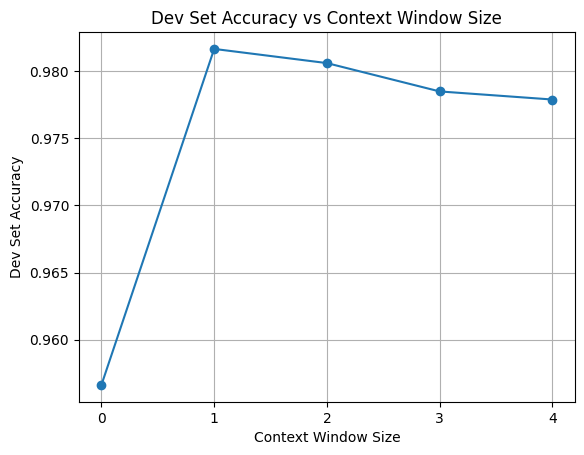

In [172]:
plt.plot(context_window, accuracies, marker='o')
plt.title('Dev Set Accuracy vs Context Window Size')
plt.xlabel('Context Window Size')
plt.ylabel('Dev Set Accuracy')
plt.xticks(context_window)
plt.grid(True)
plt.show()

In [15]:
from prettytable import PrettyTable

table_lstm = PrettyTable()

table_lstm.field_names = ["stacks", "bidirectional",
                          "hidden dim", "embedding size", "accuracy"]

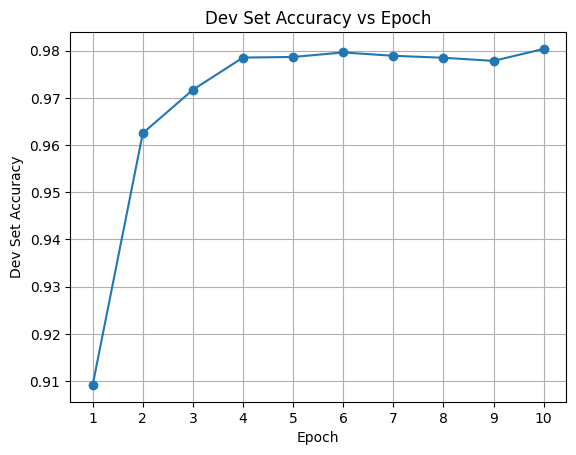

LSTM_Tagger(
  (embedding): Embedding(514, 64)
  (lstm): LSTM(64, 128, num_layers=2)
  (hidden_to_tag): Linear(in_features=128, out_features=14, bias=True)
)
Accuracy: 0.9803529803529804
Recall: 0.9803529803529804
F1 micro: 0.9803529803529804
F1 macro: 0.8740141857538392
Confusion matrix [[17382     0     0     0     0     0     0     0     0     0     0     0
      0     0]
 [    0   220     0     0     0     0     0     0     2     3     0     0
      2     0]
 [    0     4  1277     0     0     0     0     0     0     1   133     0
      0     0]
 [    0    27     0    29     1     0     0     0     0     2     0     0
      0     0]
 [    0     0     0     0   250     0     0     0     1     0     8     0
      0     7]
 [    0     0     0     0     0   107     0     0     0     0     0     0
      0     0]
 [    0     1    17     0     0     0   500     0     0     1     0    49
      0     0]
 [    0     0     0     0     0     0     0    34     0     0     0     0
      1     0]

In [16]:
train_dataset = POSDatatset_LSTM(train_filepath)
training_args = {'vocab': train_dataset.vocab, 'tags': train_dataset.tags, 'words_index': train_dataset.words_index,
                 'tags_index': train_dataset.tags_index, 'tags_one_hot': train_dataset.tags_one_hot}
dev_dataset = POSDatatset_LSTM(dev_filepath, training_args)

input_dim = len(train_dataset.vocab)
output_dim = len(train_dataset.tags)
embedding_dim = 64
hidden_dim = 128
stacks = 2
bidirectional = False

model1 = LSTM_Tagger(input_dim, embedding_dim, hidden_dim,
                     stacks, output_dim, bidirectional)
tagger = POS_Tagger('lstm')
tagger.train_graph(train_dataset, dev_dataset, model=model1)

print(tagger.model)
accuracy, recall, f1_micro, f1_macro, confusion_mat = tagger.evaluate(
    dev_dataset)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 micro:", f1_micro)
print("F1 macro:", f1_macro)
print('Confusion matrix', confusion_mat)

table_lstm.add_row(
    [stacks, bidirectional, hidden_dim, embedding_dim, accuracy])

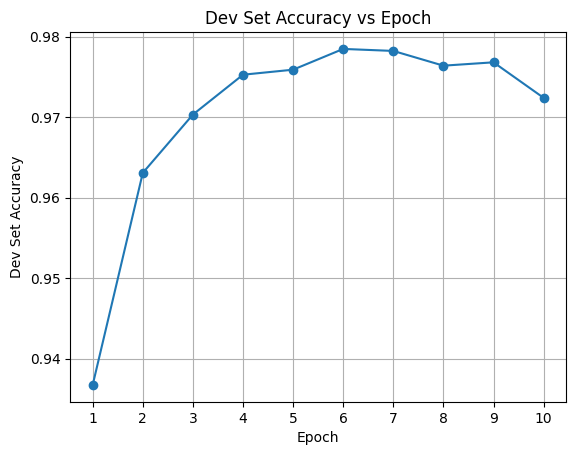

LSTM_Tagger(
  (embedding): Embedding(514, 64)
  (lstm): LSTM(64, 256, bidirectional=True)
  (hidden_to_tag): Linear(in_features=512, out_features=14, bias=True)
)
Accuracy: 0.9725690975690976
Recall: 0.9725690975690976
F1 micro: 0.9725690975690976
F1 macro: 0.8665255749135685
Confusion matrix [[17382     0     0     0     0     0     0     0     0     0     0     0
      0     0]
 [    0   218     0     0     0     0     0     0     2     5     0     0
      2     0]
 [    0     0  1091     0     0     0     0     0     0     1   323     0
      0     0]
 [    0     7     0    45     0     0     0     0     0     7     0     0
      0     0]
 [    0     0     0     0   262     0     0     0     1     0     3     0
      0     0]
 [    0     0     0     0     0   107     0     0     0     0     0     0
      0     0]
 [    0     0    12     0     0     0   483     0     0     1     0    72
      0     0]
 [    0     0     0     0     0     0     0    34     0     1     0     0
      0 

In [19]:
train_dataset = POSDatatset_LSTM(train_filepath)
training_args = {'vocab': train_dataset.vocab, 'tags': train_dataset.tags, 'words_index': train_dataset.words_index,
                 'tags_index': train_dataset.tags_index, 'tags_one_hot': train_dataset.tags_one_hot}
dev_dataset = POSDatatset_LSTM(dev_filepath, training_args)

input_dim = len(train_dataset.vocab)
output_dim = len(train_dataset.tags)
embedding_dim = 64
hidden_dim = 256
stacks = 1
bidirectional = True

model2 = LSTM_Tagger(input_dim, embedding_dim, hidden_dim,
                     stacks, output_dim, bidirectional)
tagger = POS_Tagger('lstm')
tagger.train_graph(train_dataset, dev_dataset, model=model2)

print(tagger.model)
accuracy, recall, f1_micro, f1_macro, confusion_mat = tagger.evaluate(
    dev_dataset)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 micro:", f1_micro)
print("F1 macro:", f1_macro)
print('Confusion matrix', confusion_mat)

table_lstm.add_row(
    [stacks, bidirectional, hidden_dim, embedding_dim, accuracy])

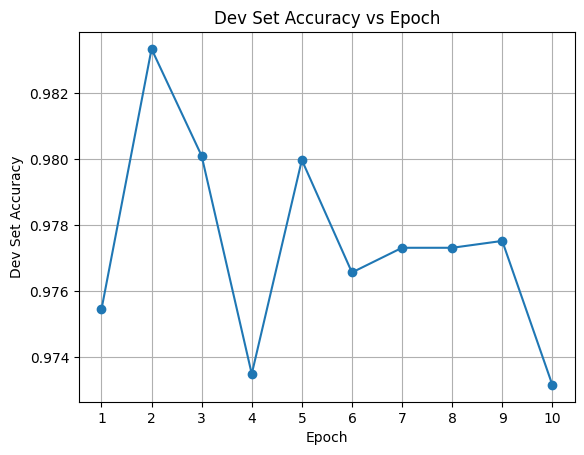

LSTM_Tagger(
  (embedding): Embedding(514, 256)
  (lstm): LSTM(256, 128, bidirectional=True)
  (hidden_to_tag): Linear(in_features=256, out_features=14, bias=True)
)
Accuracy: 0.9732350982350982
Recall: 0.9732350982350982
F1 micro: 0.9732350982350982
F1 macro: 0.8862083425185924
Confusion matrix [[17382     0     0     0     0     0     0     0     0     0     0     0
      0     0]
 [    0   207     0     4     0     0     0     0     9     5     0     0
      2     0]
 [    0     0   991     0     0     0     0     0     0     1   423     0
      0     0]
 [    0     6     0    45     0     0     0     0     1     7     0     0
      0     0]
 [    0     0     0     0   260     0     0     0     0     0     6     0
      0     0]
 [    0     0     0     0     0   107     0     0     0     0     0     0
      0     0]
 [    0     0    12     0     0     0   492     0     0     1     0    63
      0     0]
 [    0     0     0     0     0     0     0    35     0     0     0     0
      

In [27]:
train_dataset = POSDatatset_LSTM(train_filepath)
training_args = {'vocab': train_dataset.vocab, 'tags': train_dataset.tags, 'words_index': train_dataset.words_index,
                 'tags_index': train_dataset.tags_index, 'tags_one_hot': train_dataset.tags_one_hot}
dev_dataset = POSDatatset_LSTM(dev_filepath, training_args)

input_dim = len(train_dataset.vocab)
output_dim = len(train_dataset.tags)
embedding_dim = 256
hidden_dim = 128
stacks = 1
bidirectional = True

model3 = LSTM_Tagger(input_dim, embedding_dim, hidden_dim,
                     stacks, output_dim, bidirectional)
tagger = POS_Tagger('lstm')
tagger.train_graph(train_dataset, dev_dataset, model=model3)

print(tagger.model)
accuracy, recall, f1_micro, f1_macro, confusion_mat = tagger.evaluate(
    dev_dataset)
print("Accuracy:", accuracy)
priweightednt("Recall:", recall)
print("F1 micro:", f1_micro)
print("F1 macro:", f1_macro)
print('Confusion matrix', confusion_mat)

table_lstm.add_row(
    [stacks, bidirectional, hidden_dim, embedding_dim, accuracy])

In [177]:
print(table_lstm)

+--------+---------------+------------+----------------+--------------------+
| stacks | bidirectional | hidden dim | embedding size |      accuracy      |
+--------+---------------+------------+----------------+--------------------+
|   2    |     False     |    128     |       64       | 0.9828921078921079 |
|   1    |      True     |    256     |       64       | 0.9782301032301032 |
|   1    |      True     |    128     |      256       | 0.9720695970695971 |
+--------+---------------+------------+----------------+--------------------+


In [10]:
train_dataset = POSDatatset_LSTM(train_filepath)
training_args = {'vocab': train_dataset.vocab, 'tags': train_dataset.tags, 'words_index': train_dataset.words_index,
                 'tags_index': train_dataset.tags_index, 'tags_one_hot': train_dataset.tags_one_hot}
dev_dataset = POSDatatset_LSTM(dev_filepath, training_args)

input_dim = len(train_dataset.vocab)
output_dim = len(train_dataset.tags)
embedding_dim = 64
hidden_dim = 128
stacks = 2
activation = nn.ReLU()
bidirectional = False

best_model = LSTM_Tagger(input_dim, embedding_dim, hidden_dim,
                     stacks, output_dim, bidirectional)
tagger = POS_Tagger('lstm')
tagger.train(train_dataset, dev_dataset, model=best_model)

print(tagger.model)
accuracy, recall, f1_micro, f1_macro, confusion_mat = tagger.evaluate(
    dev_dataset)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 micro:", f1_micro)
print("F1 macro:", f1_macro)
print('Confusion matrix', confusion_mat)


LSTM_Tagger(
  (embedding): Embedding(514, 64)
  (lstm): LSTM(64, 128, num_layers=2)
  (hidden_to_tag): Linear(in_features=128, out_features=14, bias=True)
)
Accuracy: 0.9816849816849816
Recall: 0.9816849816849816
F1 micro: 0.9816849816849816
F1 macro: 0.8828974862201834
Confusion matrix [[17382     0     0     0     0     0     0     0     0     0     0     0
      0     0]
 [    0   216     0     3     0     0     0     0     0     6     0     0
      2     0]
 [    0     0  1347     0     0     0     0     0     0     1    67     0
      0     0]
 [    0    13     0    38     0     0     0     0     0     8     0     0
      0     0]
 [    0     0     0     0   257     0     0     0     1     0     0     0
      0     8]
 [    0     0     0     0     0   107     0     0     0     0     0     0
      0     0]
 [    0     0    13     0     0     0   476     3     0     5     0    71
      0     0]
 [    0     0     0     1     0     0     0    34     0     0     0     0
      0     0]